# Xarray + Cloud OISST (One-Month) Basics & Stats

This notebook demonstrates basic **xarray** operations on a **one-month** subset of a cloud-hosted climate dataset: **NOAA OISST v2.1 daily SST** on AWS Public Datasets (NetCDF files). You'll:
- Discover files for one month on S3 with `fsspec`
- Open them with `xarray.open_mfdataset` (anonymous S3)
- Inspect dataset structure
- Subset in space (and within that month)
- Compute basic stats (mean, std, anomalies relative to the month’s mean)
- Make maps of the month-mean and variability

**Deliverables:** Answer the **🧩 Questions** in the markdown prompts. Fill in the code where indicated by `# TODO`.


In [46]:
import xarray as xr
print(xr.backends.list_engines())
print(xr.__version__)

{'netcdf4': <NetCDF4BackendEntrypoint>
  Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using netCDF4 in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.NetCDF4BackendEntrypoint.html, 'h5netcdf': <H5netcdfBackendEntrypoint>
  Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using h5netcdf in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.H5netcdfBackendEntrypoint.html, 'scipy': <ScipyBackendEntrypoint>
  Open netCDF files (.nc, .nc4, .cdf and .gz) using scipy in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.ScipyBackendEntrypoint.html, 'store': <StoreBackendEntrypoint>
  Open AbstractDataStore instances in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.StoreBackendEntrypoint.html, 'zarr': <ZarrBackendEntrypoint>
  Open zarr files (.zarr) using zarr in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.Z

In [47]:
import xarray as xr
import fsspec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 120


## 1) Open the cloud dataset (NetCDF on AWS, one month) 

#We'll access **NOAA OISST v2.1 (daily)** in the NOAA CDR bucket on AWS. Files are arranged by **YYYYMM**.

**🧩 Questions**
1. What engine are we using to read NetCDF files from S3?
    * The engine is h5netcdf
2. Why do we need `storage_options={'anon': True}`?
    * This shows the data is open source
3. Inspect dataset attributes: what are the units and long name of `sst`
    * The units are Celsius
    * The long name is Sea Surface Temperature


In [56]:
yearmonth = "201909"  # TODO: try other months like "201507" or "201909"
prefix = f"noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/{yearmonth}/oisst-avhrr-v02r01.*.nc"

fs = fsspec.filesystem("s3", anon=True)
paths = sorted(fs.glob(prefix))
print(f"Found {len(paths)} files for {yearmonth}. Example:", paths[:2])

urls = [f"s3://{p}" for p in paths]

ds = xr.open_mfdataset(
    urls,
    engine="h5netcdf",
    combine="by_coords",
    decode_times=True,
    mask_and_scale=True,
    backend_kwargs={"storage_options": {"anon": True}},
    chunks={"time": 1}
)

ds


Found 30 files for 201909. Example: ['noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/201909/oisst-avhrr-v02r01.20190901.nc', 'noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/201909/oisst-avhrr-v02r01.20190902.nc']


<xarray.Dataset> Size: 498MB
Dimensions:  (time: 30, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 240B 2019-09-01T12:00:00 ... 2019-09-30T12...
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * zlev     (zlev) float32 4B 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 124MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 124MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 124MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    sst      (time, zlev, lat, lon) float32 124MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/37)
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    naming_authority:           gov.noaa.ncei
    cdm_data_type:              Grid
    date_modified:              2020-01-18T10:07:00Z
    date_created:               2020-01-18T10:07:00Z
    processing_level:           NOAA Level 4
    ...                         ...
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    product_version:            Version v02r01
    platform:                   Ships, buoys, Argo floats, MetOp-A, MetOp-B
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    id:                         oisst-avhrr-v02r01.20190901.nc

In [57]:
print(ds['sst'].units)


Celsius


## 2) Explore coordinates & variables

**🧩 Questions**
1. What are the coordinate names for time and space?
    * The coordinate name for time is 'time'
    * The coordinate names for space are 'lat' and 'lon'
2. What is the shape of `sst`?
    * The shape of sst is (30, 1, 720, 1440)
3. How are missing values represented?
    * There is no value stating how they are represented below. 
    * ** However, later on I encountered a 'nan' issue showing that is how they are represented


In [58]:
list(ds.data_vars), list(ds.coords)

(['anom', 'err', 'ice', 'sst'], ['time', 'lat', 'lon', 'zlev'])

In [59]:
print(ds['sst'].shape)

(30, 1, 720, 1440)


In [60]:
print(ds['sst'].attrs)


{'long_name': 'Daily sea surface temperature', 'valid_min': np.int16(-300), 'valid_max': np.int16(4500), 'units': 'Celsius'}


## 3) Time & space subsetting

We'll select a **regional box** (e.g., Gulf of Mexico) within this month.

**🧩 Questions**
1. What lon/lat bounds did you choose?
    * I chose the approximate lat and lon for the Gulf of California (116W-106W & 22N-33N)
2. How many daily steps are present in this month?
    * There are 30 daily steps, since September has 30 days.


In [73]:
var = "sst"

lon_min, lon_max = -116, -106   # TODO
lat_min, lat_max =  22,  33   # TODO

def to_0360(lon):
    lon = np.asarray(lon)
    out = np.mod(lon, 360.0)
    out[out < 0] += 360.0
    return out

lon_min_0360, lon_max_0360 = to_0360([lon_min, lon_max])

dss = ds.sel(
    lon=slice(lon_min_0360, lon_max_0360),
    lat=slice(lat_min, lat_max)
)

dss[var]


<xarray.DataArray 'sst' (time: 30, zlev: 1, lat: 44, lon: 40)> Size: 211kB
dask.array<getitem, shape=(30, 1, 44, 40), dtype=float32, chunksize=(1, 1, 44, 40), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 240B 2019-09-01T12:00:00 ... 2019-09-30T12...
  * lat      (lat) float32 176B 22.12 22.38 22.62 22.88 ... 32.38 32.62 32.88
  * lon      (lon) float32 160B 244.1 244.4 244.6 244.9 ... 253.4 253.6 253.9
  * zlev     (zlev) float32 4B 0.0
Attributes:
    long_name:  Daily sea surface temperature
    valid_min:  -300
    valid_max:  4500
    units:      Celsius

## 4) Basic statistics

Compute region-wide stats through time and over space **within this month**.

**🧩 Questions**
1. Compute the spatial mean SST time series over your box. What is the monthly average and standard deviation?
    * The spatial mean is 27.07°C and the standard deviation is 0.52°C
2. Compute within-month anomalies (subtract the month-mean). What are the largest positive and negative anomalies?
    * The largest positive anomaly was 0.72°C
    * The largest negative anomaly was -0.997°C
3. What day had the warmest/coolest region-mean SST?
    * The warmest day was 2019-09-07 with a temperature of 27.79°C
    * The coldest day was 2019-09-30 with a temperature of 26.07°C

Month mean SST (°C): 27.06890869140625
Month std SST (°C): 0.5162867307662964


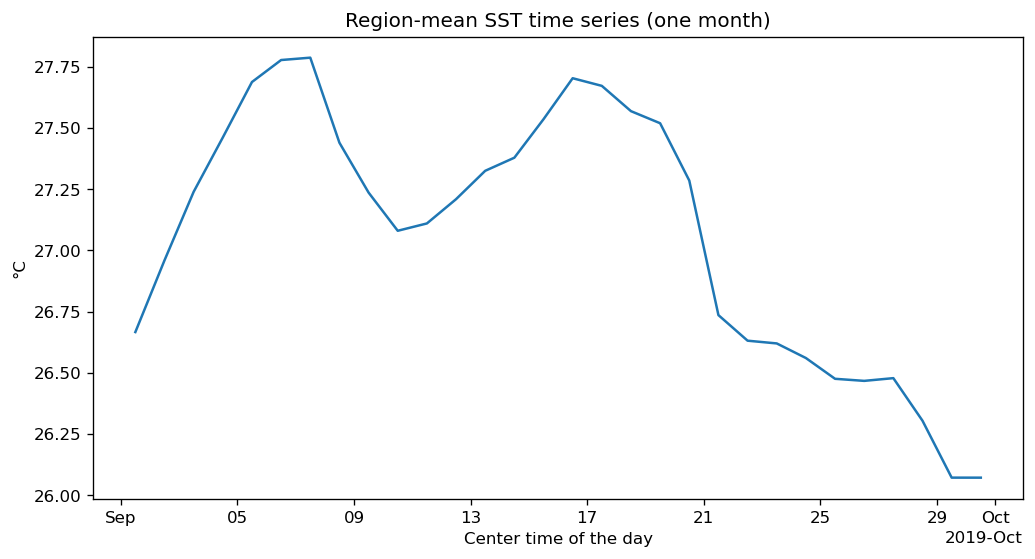

Warmest day: 2019-09-07 27.787803649902344
Coolest day: 2019-09-30 26.071575164794922


/tmp/ipykernel_37130/4235597154.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Warmest day:', pd.to_datetime(ts.time[imax].values).date(), float(ts.isel(time=imax).values))
/tmp/ipykernel_37130/4235597154.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Coolest day:', pd.to_datetime(ts.time[imin].values).date(), float(ts.isel(time=imin).values))


In [74]:
ts = dss[var].mean(dim=['lat','lon'])

ts_mean = ts.mean().compute()
ts_std  = ts.std().compute()
print('Month mean SST (°C):', float(ts_mean.values))
print('Month std SST (°C):', float(ts_std.values))

ts.load().plot()
plt.title('Region-mean SST time series (one month)')
plt.ylabel('°C')
plt.show()

imax = int(ts.argmax('time'))
imin = int(ts.argmin('time'))
print('Warmest day:', pd.to_datetime(ts.time[imax].values).date(), float(ts.isel(time=imax).values))
print('Coolest day:', pd.to_datetime(ts.time[imin].values).date(), float(ts.isel(time=imin).values))


Max anomaly (°C): 0.7188962697982788
Min anomaly (°C): -0.9973366260528564


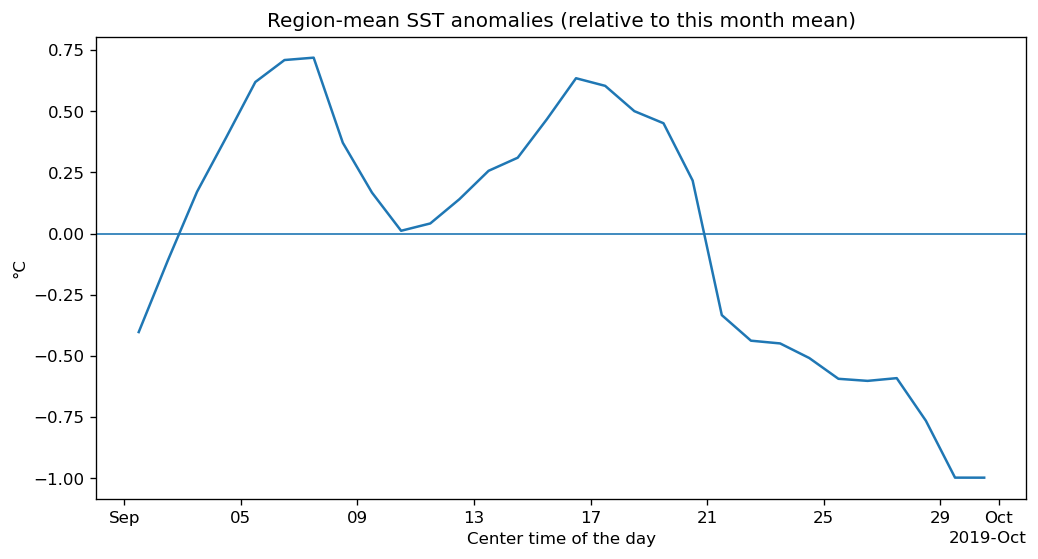

In [75]:
month_mean = dss[var].mean('time')
anom = dss[var] - month_mean

ts_anom = anom.mean(dim=['lat','lon'])
print('Max anomaly (°C):', float(ts_anom.max().compute().values))
print('Min anomaly (°C):', float(ts_anom.min().compute().values))

ts_anom.load().plot()
plt.title('Region-mean SST anomalies (relative to this month mean)')
plt.axhline(0, lw=1)
plt.ylabel('°C')
plt.show()


## 5) Regional maps: month-mean and variability

Make maps of month-mean SST and within-month variability (std and range).

**🧩 Questions**
1. What patterns do you notice?
    * The mean sea surface temperatures appear to be warmer inside the gulf versus the Pacific ocean, as well as moving south. There also appears to be some warmer spots slightly off the coast.
2. Where is variability strongest?
    * Variability seems to be the strongest at about 26°N 246°E


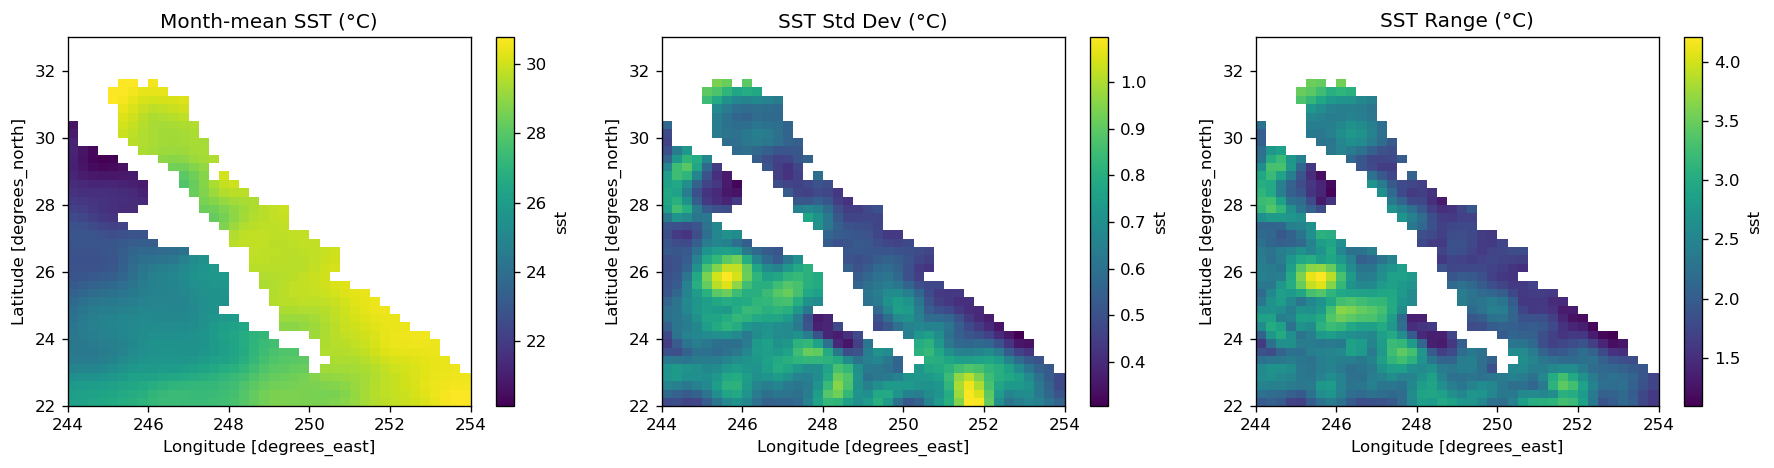

In [77]:
mean_sst = dss[var].mean('time')
std_sst  = dss[var].std('time')
range_sst = dss[var].max('time') - dss[var].min('time')

fig = plt.figure(figsize=(15,4))
ax = plt.subplot(1,3,1); mean_sst.plot(ax=ax); ax.set_title('Month-mean SST (°C)')
ax = plt.subplot(1,3,2); std_sst.plot(ax=ax); ax.set_title('SST Std Dev (°C)')
ax = plt.subplot(1,3,3); range_sst.plot(ax=ax); ax.set_title('SST Range (°C)')
plt.tight_layout(); plt.show()


## 6) Export a small subset for sharing (Check In Problem for Module 2)

Write a NetCDF with your regional mean time series and month-mean/variability maps.  Upload with your committed repository.

In [78]:
ds_new = xr.Dataset(
    data_vars={
        'sst' : dss['sst'],
        'mean_sst': mean_sst,
        'std_sst': std_sst,
        'range_sst': range_sst,
    },
    coords=dss.coords
)

In [79]:
path='Gulf_of_California_SST.nc'
ds_new.to_netcdf(path)